In [1]:
import time
import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPClassifier
import shap

SEED = 260420010

In [2]:
classification_target = 'CAUSE'

In [4]:
df = pd.read_csv('../data/4_one_hot/processed_data_CAUSE_dropped.csv')
X, y = df.drop(columns=[classification_target]), df[classification_target]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.6, shuffle=True, random_state=SEED)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

Mamy problem klasyfikacji wieloklasowej. Jako dolny poziom odniesienia weźmiemy `DummyClassifier`, który cały czas będzie przewidywał najczęstszą etyketę.

Najpierw przeskalujemy dane do rozkładu `D(mu=0, sigma^2=1)`.

In [5]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [6]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_valid)
print(classification_report(y_valid, y_pred_dummy))

                                  precision    recall  f1-score   support

               CORROSION FAILURE       0.00      0.00      0.00       300
               EQUIPMENT FAILURE       0.35      1.00      0.52       574
               EXCAVATION DAMAGE       0.00      0.00      0.00       164
             INCORRECT OPERATION       0.00      0.00      0.00       203
MATERIAL FAILURE OF PIPE OR WELD       0.00      0.00      0.00       102
            NATURAL FORCE DAMAGE       0.00      0.00      0.00        91
            OTHER ACCIDENT CAUSE       0.00      0.00      0.00        22
            OTHER INCIDENT CAUSE       0.00      0.00      0.00        29
      OTHER OUTSIDE FORCE DAMAGE       0.00      0.00      0.00       126
    PIPE, WELD, OR JOINT FAILURE       0.00      0.00      0.00        16

                        accuracy                           0.35      1627
                       macro avg       0.04      0.10      0.05      1627
                    weighted avg    

/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

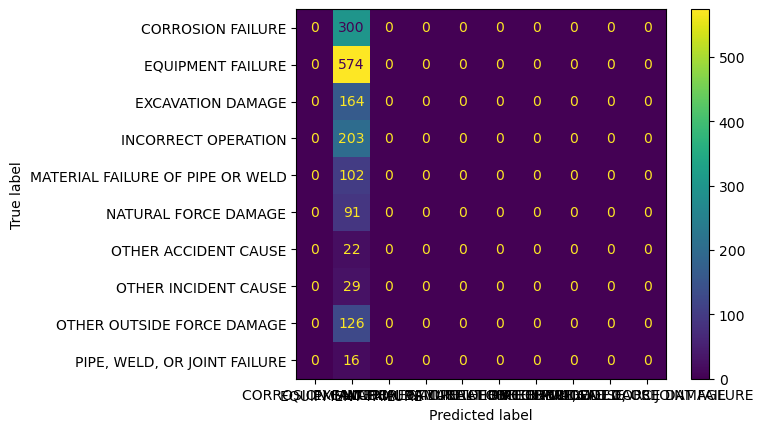

In [7]:
ConfusionMatrixDisplay(confusion_matrix(y_valid, y_pred_dummy, labels=dummy.classes_), display_labels=dummy.classes_).plot()

To idziemy dalej i sprobujmy przewidywać logistyczną regresją.

In [8]:
log_reg = LogisticRegression(penalty='l2', multi_class='multinomial')
log_reg.fit(X_train, y_train)
y_log_reg_pred = log_reg.predict(X_valid)
print(classification_report(y_valid, y_log_reg_pred))

                                  precision    recall  f1-score   support

               CORROSION FAILURE       0.46      0.47      0.47       300
               EQUIPMENT FAILURE       0.56      0.85      0.68       574
               EXCAVATION DAMAGE       0.50      0.60      0.54       164
             INCORRECT OPERATION       0.18      0.01      0.02       203
MATERIAL FAILURE OF PIPE OR WELD       0.32      0.42      0.36       102
            NATURAL FORCE DAMAGE       0.12      0.01      0.02        91
            OTHER ACCIDENT CAUSE       0.00      0.00      0.00        22
            OTHER INCIDENT CAUSE       0.33      0.03      0.06        29
      OTHER OUTSIDE FORCE DAMAGE       0.49      0.37      0.42       126
    PIPE, WELD, OR JOINT FAILURE       0.20      0.12      0.15        16

                        accuracy                           0.51      1627
                       macro avg       0.32      0.29      0.27      1627
                    weighted avg    

/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [9]:
pd.DataFrame(data=np.sort(log_reg.coef_, axis=1), index=list(np.unique(y_log_reg_pred)).remove('PIPE, WELD, OR JOINT FAILURE'), columns=X.columns)

,case_lat,case_lon,case_date,FEDERAL,inst_age_in_days,MOP_PSIG,TAVG,case_date_sin,COMMODITY_RELEASED_TYPE_BIOFUEL / ALTERNATIVE FUEL(INCLUDING ETHANOL BLENDS),COMMODITY_RELEASED_TYPE_CO2 (CARBON DIOXIDE),...,PIPELINE_FUNCTION_TYPE B GATHERING,PIPELINE_FUNCTION_TYPE C GATHERING,zone_Cold,zone_Hot-Dry,zone_Hot-Humid,zone_Marine,zone_Mixed-Dry,zone_Mixed-Humid,zone_Subarctic,zone_Very Cold
0,-0.679333,-0.574858,-0.441151,-0.350227,-0.328540,-0.324518,-0.284263,-0.256221,-0.230386,-0.228910,...,0.151656,0.175840,0.185707,0.208308,0.241936,0.268954,0.273563,0.316188,0.382528,0.545824
1,-0.748670,-0.536980,-0.431579,-0.392351,-0.383911,-0.369522,-0.314575,-0.204022,-0.198681,-0.124193,...,0.257470,0.265646,0.267357,0.323354,0.325009,0.330162,0.335433,0.335650,0.487550,0.529250
2,-0.597948,-0.465254,-0.353278,-0.323556,-0.306755,-0.281385,-0.271979,-0.234327,-0.158806,-0.149974,...,0.189136,0.213210,0.233279,0.269524,0.305842,0.311532,0.325298,0.389172,0.417695,0.544439
3,-0.482062,-0.449856,-0.362935,-0.341300,-0.330533,-0.322444,-0.272130,-0.217119,-0.212993,-0.163567,...,0.165050,0.174325,0.178122,0.190333,0.208854,0.209664,0.219443,0.238522,0.254403,0.347633
4,-0.596056,-0.540748,-0.450820,-0.412764,-0.384071,-0.373639,-0.372647,-0.352606,-0.304648,-0.267888,...,0.129378,0.164891,0.184796,0.257267,0.262343,0.337963,0.359226,0.455817,0.531536,0.545497
5,-0.211647,-0.204998,-0.184027,-0.169694,-0.160143,-0.147296,-0.137417,-0.134598,-0.123845,-0.120721,...,0.128370,0.133482,0.143150,0.160143,0.160552,0.180365,0.204010,0.206574,0.250014,0.356006
6,-0.854784,-0.812478,-0.592818,-0.514623,-0.467417,-0.434624,-0.274217,-0.264279,-0.234457,-0.223080,...,0.217532,0.234653,0.254214,0.286317,0.301073,0.383464,0.411751,0.413755,0.463121,0.480275
7,-0.507637,-0.466705,-0.371474,-0.351993,-0.345521,-0.342321,-0.341359,-0.329032,-0.288718,-0.264839,...,0.216119,0.244437,0.256708,0.293406,0.294881,0.323219,0.341702,0.345964,0.559808,0.721443
8,-0.496853,-0.328341,-0.314684,-0.267041,-0.220019,-0.212325,-0.201951,-0.171765,-0.170531,-0.164242,...,0.150709,0.168383,0.175032,0.183166,0.212325,0.232919,0.236098,0.297083,0.319022,0.503657
9,-0.420108,-0.416200,-0.405171,-0.364198,-0.357619,-0.239436,-0.227734,-0.227434,-0.226384,-0.181605,...,0.261569,0.299709,0.337966,0.367447,0.391347,0.403577,0.425141,0.443488,0.447970,0.562689


In [10]:
import eli5
eli5.show_prediction(log_reg)

ImportError: cannot import name 'if_delegate_has_method' from 'sklearn.utils.metaestimators' (/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/sklearn/utils/metaestimators.py)

Widać że linijowy model źle się dopasował, zatem sprobujmy najpierw zastosować SVC z jądrem. On się pokazał źle, dlatego wykorzystajmy zwykły linijowy SVC z hinge loss.

In [ ]:
svc = SVC(kernel='rbf', random_state=SEED)
svc.fit(X_train, y_train)
y_log_reg_pred = svc.predict(X_valid)
print(classification_report(y_valid, y_log_reg_pred))

                                  precision    recall  f1-score   support

               CORROSION FAILURE       0.49      0.43      0.46       304
               EQUIPMENT FAILURE       0.57      0.88      0.69       581
               EXCAVATION DAMAGE       0.48      0.53      0.50       152
             INCORRECT OPERATION       0.67      0.01      0.02       198
MATERIAL FAILURE OF PIPE OR WELD       0.30      0.45      0.36       109
            NATURAL FORCE DAMAGE       0.67      0.02      0.04        90
            OTHER ACCIDENT CAUSE       0.00      0.00      0.00        27
            OTHER INCIDENT CAUSE       1.00      0.06      0.11        36
      OTHER OUTSIDE FORCE DAMAGE       0.43      0.43      0.43       114
    PIPE, WELD, OR JOINT FAILURE       0.00      0.00      0.00        16

                        accuracy                           0.51      1627
                       macro avg       0.46      0.28      0.26      1627
                    weighted avg    

/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Sprobujmy polepszyć wynik za pomocą bardziej złożonych modeli, takich jak MLP

In [ ]:
params = {"hidden_layer_sizes": [(np.ones(50) * 50).astype(int), (np.ones(100) * 100).astype(int)], 'alpha': [0.0001, 0.001, 0.01]}
mlp_classifier = MLPClassifier(activation='relu', solver= 'sgd', learning_rate='adaptive',
          momentum=0.7, nesterovs_momentum=True, early_stopping=True)
grid_search_cv = GridSearchCV(mlp_classifier, param_grid=params, cv=5)
grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=MLPClassifier(early_stopping=True,
                                     learning_rate='adaptive', momentum=0.7,
                                     solver='sgd'),
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]),
                                                array([100, 100,...
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100])]})

Najlepsze parametry:
`{'alpha': 0.0001,
 'hidden_layer_sizes': (np.ones(50) * 50).astype(int)}`

In [ ]:
mlp_classifier = MLPClassifier()
mlp_classifier.fit(X_train, y_train)

/Users/ivansmaliakou/opt/anaconda3/envs/AGH_default/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [ ]:
y_mlp_classifier_pred = mlp_classifier.predict(X_valid)
print(classification_report(y_valid, y_mlp_classifier_pred))

                                  precision    recall  f1-score   support

               CORROSION FAILURE       0.46      0.50      0.48       304
               EQUIPMENT FAILURE       0.58      0.80      0.67       581
               EXCAVATION DAMAGE       0.44      0.51      0.47       152
             INCORRECT OPERATION       0.25      0.08      0.12       198
MATERIAL FAILURE OF PIPE OR WELD       0.31      0.25      0.28       109
            NATURAL FORCE DAMAGE       0.12      0.04      0.06        90
            OTHER ACCIDENT CAUSE       0.00      0.00      0.00        27
            OTHER INCIDENT CAUSE       0.23      0.08      0.12        36
      OTHER OUTSIDE FORCE DAMAGE       0.38      0.37      0.38       114
    PIPE, WELD, OR JOINT FAILURE       0.15      0.12      0.14        16

                        accuracy                           0.48      1627
                       macro avg       0.29      0.27      0.27      1627
                    weighted avg    